<a href="https://colab.research.google.com/github/KyleRoss-rice/SignIconicityPredictor/blob/main/tools/Dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Preparation
Process the ASL-Lex 2.0 dataset into an appropriate dataset for regression and classification tasks. 

The regression target feature is **Non-Signer Iconicity**.  
The classification target feature is **Iconicity Type**.

This script generates training and testing _.csv_ files for both tasks.

## Import libraries

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno

from google.colab import files
from sklearn import feature_extraction

## Fetch original ASL-LEX 2.0 dataset from our server


In [102]:
!wget notcol.net/research/mlproject/ASL-LEX2_Oct21_2020.csv

--2020-11-14 21:59:52--  http://notcol.net/research/mlproject/ASL-LEX2_Oct21_2020.csv
Resolving notcol.net (notcol.net)... 192.99.169.208
Connecting to notcol.net (notcol.net)|192.99.169.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3480805 (3.3M) [text/csv]
Saving to: ‘ASL-LEX2_Oct21_2020.csv’

ASL-LEX2_Oct21_2020 100%[===================>]   3.32M  2.37MB/s    in 1.4s    

2020-11-14 21:59:54 (2.37 MB/s) - ‘ASL-LEX2_Oct21_2020.csv’ saved [3480805/3480805]



## Create pandas object from the source dataset

In [103]:
source_data = pd.read_csv('ASL-LEX2_Oct21_2020.csv')
working_data = source_data.copy()

n_rows = len(source_data)
n_columns = len(source_data.columns)

working_data

,Entry ID,Lemma ID,Batch,List,Item,English Word Frequency,Frequency,Frequency SD,Frequency Z,Frequency N,Frequency (Native),Frequency Sd (Native),Frequency Z (Native),Frequency N (Native),Frequency (Nonnative),Frequency SD (Nonnative),Frequency N (Nonnative),Frequency Z (Nonnative),Dominant English Translation,Sign Unknown (%),English Translation Agreement (%),Unknown To Participant (%) (Native),English Name Agreement (%) (Native),Unknown To Participant (%) (Nonnative),English Name Agreement (%) (Nonnative),Non-Signer Iconicity,Non-Signer Iconicity SD,Non-Signer Iconicity Z,Non-Signer Iconicity N,Non-Signer Iconicity SD.1,Iconicity Type,Deaf Signer Iconicity,Deaf Signer Iconicity SD (Native),Deaf Signer Iconicity N,Deaf Signer Iconicity Z,Deaf Signer Iconicity (Native),Deaf Signer Iconicity SD (Native).1,Deaf Signer Iconicity Z (Native),Deaf Signer Iconicity N (Native),English Translation Agreement,...,Nondominant Handshape M5,Wrist Twist M5,Handshape M6,Selected Fingers M6,Flexion M6,Flexion Change M6,Spread M6,Spread Change M6,Thumb Position M6,Thumb Contact M6,Sign Type M6,Movement M6,Repeated Movement M6,Major Location M6,Minor Location M6,Second Minor Location M6,Contact M6,Nondominant Handshape M6,Wrist Twist M6,Sign Type Frequency,Major Location Frequency,Minor Location Frequency,Second Minor Location Frequency,Movement Frequency,Selected Fingers Frequency,Flexion Frequency,Flexion Change Frequency,Repeated Movement Frequency,Contact Frequency,Spread Frequency,Spread Change Frequency,Thumb Contact Frequency,Thumb Position Frequency,Ulnar Rotatio Nfrequency,Phonotactic Probability,Parameter Neighborhood Density,Neighborhood Density,SignBank Reference ID,Age Of Acquisition,Age Of Acquisition (Empirical)
0,1_dollar,1_dollar,C,2.0,25.0,NaN,3.034,1.500,-0.728,29,2.944,1.474,-0.843,18,3.182,1.601,12,-0.541,NaN,NaN,NaN,NaN,NaN,0.083,NaN,1.074,0.267,-0.820,27.0,NaN,Arbitrary,2.10,1.45,30.0,-0.42,2.29,1.49,-0.37,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175,0.250,0.019,0.155,0.457,0.449,0.225,0.209,0.446,0.622,0.602,NaN,0.684,0.657,0.836,-0.020,383,NaN,1268.0,NaN,NaN
1,5_dollars,5_dollars,B,1.0,62.0,NaN,5.120,1.716,0.302,25,5.214,1.847,0.360,14,5.000,1.612,11,0.228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.481,1.503,1.308,27.0,NaN,Perceptual,3.10,1.40,31.0,0.09,2.91,1.31,0.04,22.0,2.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.392,0.363,0.363,NaN,0.153,0.449,0.409,0.791,0.554,0.378,0.398,0.878,0.684,0.657,0.164,0.281,190,4.0,2436.0,NaN,NaN
2,8_hour,8_hour,C,2.0,55.0,NaN,4.267,1.574,-0.025,30,4.444,1.723,-0.031,18,4.000,1.348,12,-0.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.654,1.623,-0.101,26.0,NaN,Arbitrary,2.53,1.85,30.0,-0.19,2.52,1.78,-0.27,21.0,2.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175,0.250,0.015,0.025,0.076,0.045,0.225,0.791,0.554,0.622,NaN,NaN,0.316,0.657,0.836,-0.396,129,NaN,2437.0,NaN,NaN
3,9_oclock,9_oclock,C,2.0,80.0,NaN,4.133,1.592,-0.122,30,4.778,1.478,0.129,18,3.167,1.267,12,-0.497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.741,1.430,0.034,27.0,NaN,Arbitrary,3.23,2.03,30.0,0.14,3.24,2.17,0.06,21.0,1.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.392,0.026,0.004,NaN,0.457,0.261,0.162,0.791,0.554,0.622,NaN,NaN,0.684,0.343,0.836,-0.252,48,4.0,2857.0,NaN,NaN
4,a-line_bob,a-line_bob,K,NaN,NaN,NaN,4.273,1.804,0.030,25,4.500,1.069,0.349,11,4.143,2.143,14,-0.152,NaN,0.12,NaN,0.273,NaN,NaN,NaN,3.769,1.925,-0.047,26.0,BOB HAIRCUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345,0.266,0.066,0.178,0.233,0.449,0.162,0.791,0.554,0.378,0.602,0.878,0.684,0.657,0.164,0.089,158,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Correct typos

In [104]:
working_data.rename(columns={'Ulnar Rotatio Nfrequenecy': 'Ulnar Rotation Frequency'});

## Feature selection

#### Remove handpicked features that are unrelated to psycholinguistic properties or that are evidently highly coviarate

In [105]:
features_to_trim = ['Entry ID', 'Lemma ID',
                    'Batch', 'List', 'Item', 'Sign Onset (ms)', 'Sign Offset (ms)', 
                    'Duration (ms)', 'Video Length (ms)', 'In CDI', 'English Word Frequency',
                    'Frequency SD', 'Frequency N', 'Frequency Z', #Keep the Frequency mean
                    'Frequency SD (Nonnative)', 'Frequency N (Nonnative)', 'Frequency Z (Nonnative)', #Keep the Frequency (Nonnative) mean
                    'Frequency Sd (Native)', 'Frequency N (Native)', 'Frequency Z (Native)', #Keep the Frequentcy (Native) mean
                    'Non-Signer Iconicity SD', 'Non-Signer Iconicity Z', 'Non-Signer Iconicity N'] #Keep the Non-Signer Iconicity mean

working_data.drop(features_to_trim, 1, inplace=True)
n_trimmed = len(features_to_trim)

print(f'Original dataset contains {n_columns} columns')
n_columns -= n_trimmed
print(f'{n_trimmed} columns were trimmed. {n_columns} columns remain')

Original dataset contains 177 columns
23 columns were trimmed. 154 columns remain


#### Keep features and entries that are at least 80% non-NA


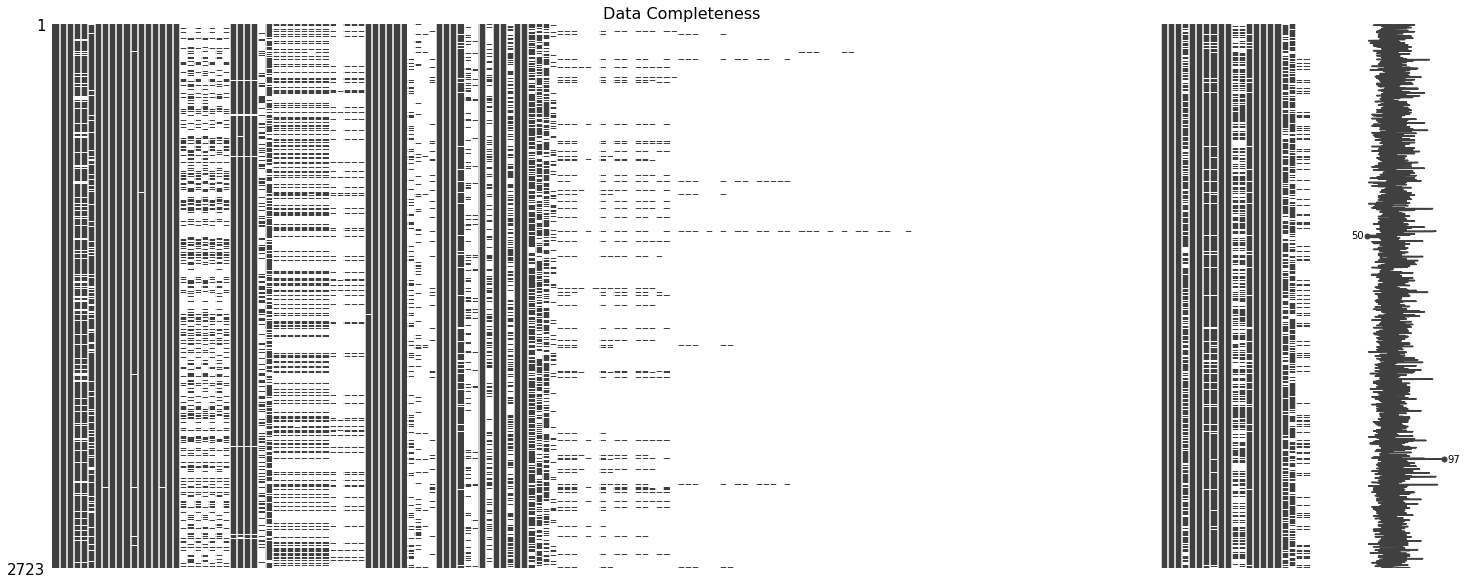

In [106]:
msno.matrix(source_data, fontsize=12)
plt.title('Data Completeness', fontsize=16);

In [107]:
#Save iconicity type feature
is_iconicity_type_dropped = False
iconicity_type_data = working_data['Iconicity Type'].values

#Drop features
working_data.dropna(1, thresh=n_rows * .8, inplace=True)

#Append back iconicity type, if required
if ('Iconicity Type' not in working_data.columns):
  is_iconicity_type_dropped = True
  working_data['Iconicity Type'] = iconicity_type_data

n_trimmed = n_columns - len(working_data.columns)
n_columns -= n_trimmed
print(f'{n_trimmed} columns were trimmed. {n_columns} columns remain')

125 columns were trimmed. 29 columns remain


In [108]:
#Drop entries
working_data.dropna(0, thresh=n_columns * .8, inplace=True)

n_trimmed = n_rows - len(working_data)
print(f'{n_trimmed} rows were trimmed. {n_rows - n_trimmed} rows remain')

0 rows were trimmed. 2723 rows remain


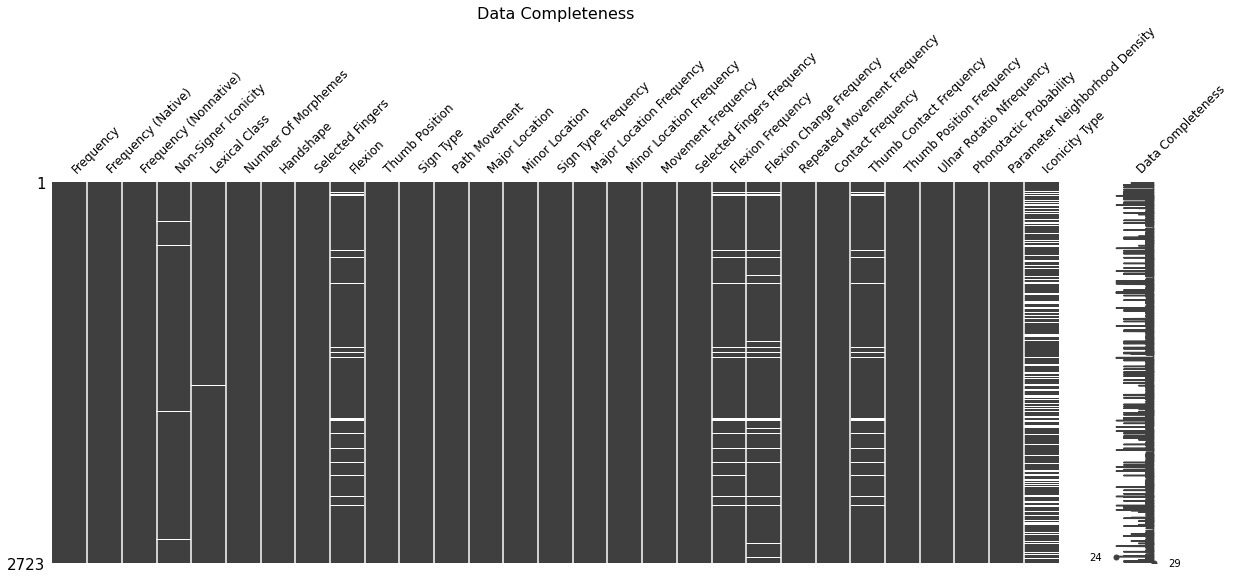

In [109]:
msno.matrix(working_data, labels=True, figsize=(20, 7), fontsize=12)
plt.title('Data Completeness', fontsize=16);

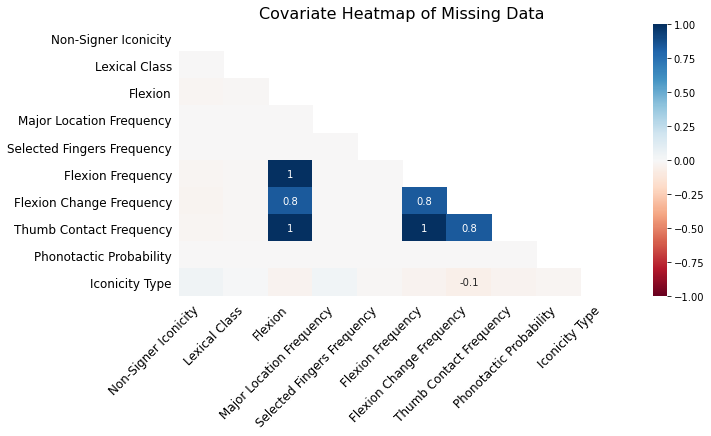

In [110]:
msno.heatmap(working_data, figsize=(10,5), fontsize=12)
plt.title('Covariate Heatmap of Missing Data', fontsize=16);

#### Drop all entries containing a NA (except for Iconicity Type)


In [111]:
#Do not drop iconicity type feature
if (is_iconicity_type_dropped):
  working_data.dropna(0, inplace=True, subset=working_data.columns[:-1])
else:
  working_data.dropna(0, inplace=True)

ndropped_rows = n_rows - len(working_data) 
print(f'{ndropped_rows} rows were dropped')
n_rows -= ndropped_rows

228 rows were dropped


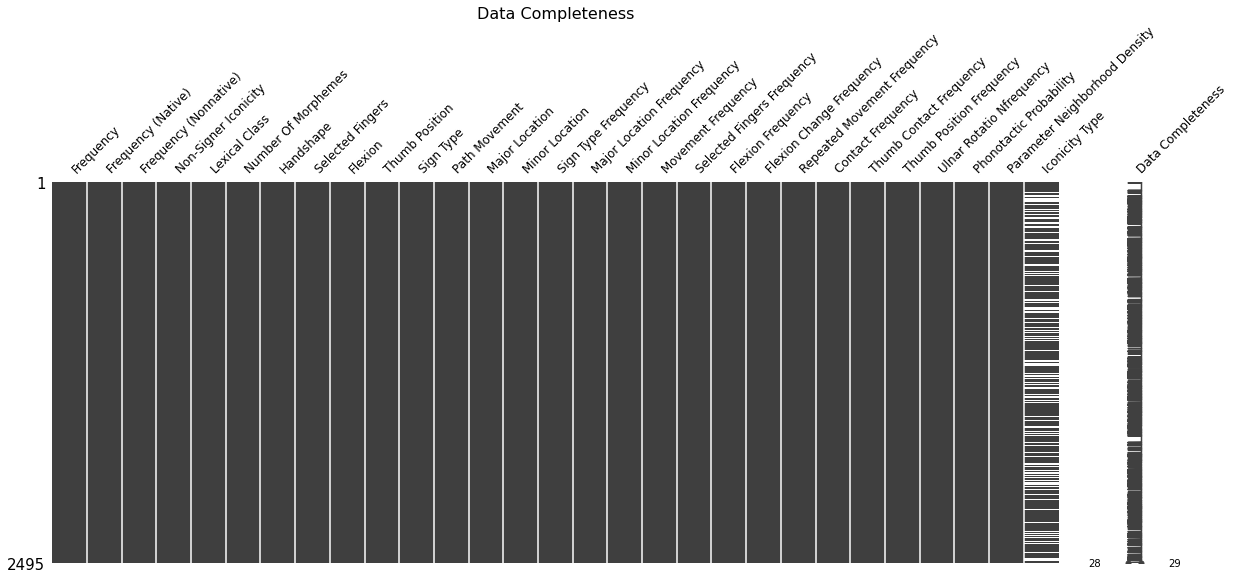

In [112]:
msno.matrix(working_data, labels=True, figsize=(20,7), fontsize=12)
plt.title('Data Completeness', fontsize=16);

## Save the indices of the remaining entries for cross referencing

In [113]:
remaining_entries_indices = working_data.index.to_list()
working_data.reset_index(drop=True, inplace=True)
working_data.insert(0, 'ASL-Lex 2.0 ID', remaining_entries_indices)

## Encode nominal data

### One-Hot and 4-bit Feature Hashing Encoding

In [114]:
def encode_one_hot(df, features_to_encode): # dataframe + features 
  n_features = len(features_to_encode) # number of features
  new_features = None # starts empty and gets filled with the for loop 
  for i in range(n_features):
    current_feature_data = df[features_to_encode[i]] # get feature "i" from the data frame
    new_features = pd.concat((new_features, pd.get_dummies(current_feature_data)), axis=1)
  return new_features

def encode_feature_hasher(df, features_to_encode, n_bits): # used for features with many categories, n_bits (# features after hashing) specifies the # of bins (features with the same hash value get assigned to the same bin)
  n_features = len(features_to_encode) # number of features to encode
  new_features = np.empty((len(df), n_features * n_bits)) # empty data frame at first 
  feature_hasher = sklearn.feature_extraction.FeatureHasher(n_features=n_bits, input_type='string') # feature hasher instance
  for i in range(n_features): # iterate over all the features 
    current_feature_data = np.array(feature_hasher.fit_transform(df[features_to_encode[i]]).toarray()) # transforms the features using the feature hasher instance
    start_pos = n_bits * i
    new_features[:, start_pos: start_pos + n_bits] = current_feature_data
  
  new_features = pd.DataFrame(new_features)
  return new_features

In [115]:
nominal_features = ('Selected Fingers', 'Lexical Class', 'Major Location', 'Minor Location',
                    'Sign Type', 'Handshape', 'Flexion', 'Path Movement')

ic = working_data['Iconicity Type']
is_ohe = (True, True, True, False, True, False, True, True)

one_hot_features = [nominal_features[i] for i, on in enumerate(is_ohe) if on]
feature_hash_features = [i for i in nominal_features if i not in one_hot_features]

new_features = encode_one_hot(working_data, one_hot_features)
new_features = pd.concat((new_features, encode_feature_hasher(working_data, feature_hash_features, 4)), axis=1)
working_data.drop(one_hot_features, axis=1, inplace=True)
working_data.drop(feature_hash_features, axis=1, inplace=True)
working_data = pd.concat((working_data, new_features), axis=1)
working_data = pd.concat((working_data, ic), axis=1)

### Label Encoding for Binary Input Features

In [116]:
label_encoder = sklearn.preprocessing.LabelEncoder()
working_data['Thumb Position'] = label_encoder.fit_transform(working_data['Thumb Position'])

In [117]:
working_data

,ASL-Lex 2.0 ID,Frequency,Frequency (Native),Frequency (Nonnative),Non-Signer Iconicity,Number Of Morphemes,Thumb Position,Sign Type Frequency,Major Location Frequency,Minor Location Frequency,Movement Frequency,Selected Fingers Frequency,Flexion Frequency,Flexion Change Frequency,Repeated Movement Frequency,Contact Frequency,Thumb Contact Frequency,Thumb Position Frequency,Ulnar Rotatio Nfrequency,Phonotactic Probability,Parameter Neighborhood Density,Iconicity Type,i,im,imp,imr,imrp,ip,m,mr,mrp,p,Adjective,Adverb,Minor,Name,Noun,Number,Verb,Arm,Body,Hand,Head,Neutral,Asymmetrical Different Handshape,Asymmetrical Same Handshape,Dominance Violation,One Handed,Symmetrical Or Alternating,Symmetry Violation,Bent,Crossed,Curved,Flat,Fully Closed,Fully Open,Stacked,Back And Forth,Circular,Curved,None,Other,Straight,X-shaped,Z-shaped,0,1,2,3,4,5,6,7,Iconicity Type
0,0,3.034,2.944,3.182,1.074,1,1,0.175,0.250,0.019,0.457,0.449,0.225,0.209,0.446,0.622,0.684,0.657,0.836,-0.020,383,Arbitrary,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.0,-1.0,-2.0,0.0,0.0,-1.0,0.0,0.0,Arbitrary
1,1,5.120,5.214,5.000,5.481,1,1,0.392,0.363,0.363,0.153,0.449,0.409,0.791,0.554,0.378,0.684,0.657,0.164,0.281,190,Perceptual,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,Perceptual
2,2,4.267,4.444,4.000,2.654,1,1,0.175,0.250,0.015,0.076,0.045,0.225,0.791,0.554,0.622,0.316,0.657,0.836,-0.396,129,Arbitrary,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,-1.0,1.0,-3.0,1.0,0.0,-1.0,0.0,0.0,Arbitrary
3,3,4.133,4.778,3.167,2.741,2,0,0.392,0.026,0.004,0.457,0.261,0.162,0.791,0.554,0.622,0.684,0.343,0.836,-0.252,48,Arbitrary,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,-1.0,0.0,-3.0,1.0,-1.0,1.0,1.0,Arbitrary
4,4,4.273,4.500,4.143,3.769,1,1,0.345,0.266,0.066,0.233,0.449,0.162,0.791,0.554,0.378,0.684,0.657,0.164,0.089,158,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.0,0.0,4.0,2.0,1.0,-1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,2717,2.556,2.917,2.267,2.813,1,0,0.345,0.094,0.032,0.457,0.449,0.162,0.791,0.446,0.622,0.684,0.343,0.836,-0.032,115,Arbitrary,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1.0,-1.0,-1.0,2.0,0.0,0.0,1.0,1.0,Arbitrary
2491,2718,4.192,4.313,4.000,6.565,1,1,0.392,0.363,0.363,0.457,0.449,0.225,0.791,0.554,0.378,0.316,0.657,0.836,0.596,482,Perceptual,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.0,1.0,1.0,-1.0,0.0,0.0,0.0,1.0,Perceptual
2492,2719,3.148,2.875,3.545,6.394,1,1,0.023,0.094,0.002,0.457,0.261,0.099,0.791,0.446,0.378,0.316,0.657,0.836,-0.694,165,Pantomimic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1.0,-1.0,1.0,-2.0,0.0,-2.0,2.0,2.0,Pantomimic
2493,2721,3.958,3.929,4.000,4.667,1,1,0.345,0.363,0.363,0.457,0.261,0.067,0.209,0.554,0.622,0.316,0.657,0.836,0.129,524,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.0,1.0,1.0,-1.0,0.0,0.0,0.0,-1.0,NaN


## Create training and testing sets

In [118]:
def create_data_files(data, filename_prefix):
  filename_suffixes = ('X_train', 'X_test', 'y_train', 'y_test')
  filename_extension = '.csv'

  for i, s in enumerate(data):
    np.savetxt(f'{filename_prefix}{filename_suffixes[i]}{filename_extension}', s, delimiter=',')

In [119]:
y_r = working_data['Non-Signer Iconicity'].values
X_r = working_data.drop('Non-Signer Iconicity', axis=1)
X_c = X_r.copy()
X_r = X_r.drop('Iconicity Type', axis=1).values
X_c = X_c.dropna()
y_c = X_c['Iconicity Type'].values[:,0]
X_c = X_c.drop('Iconicity Type', axis=1).values
y_c = label_encoder.fit_transform(y_c)

splits = sklearn.model_selection.train_test_split(X_r, y_r, test_size=0.2)
create_data_files(splits, 'regression_')
!find -maxdepth 1 -iname 'regression*.csv' -print0 | xargs -0 zip regression_data.zip
files.download('regression_data.zip')

splits = sklearn.model_selection.train_test_split(X_c, y_c, test_size=0.2)
create_data_files(splits, 'classification_')
!find -maxdepth 1 -iname 'classification*.csv' -print0 | xargs -0 zip classification_data.zip
files.download('classification_data.zip')

updating: regression_X_train.csv (deflated 96%)
updating: regression_y_test.csv (deflated 83%)
updating: regression_y_train.csv (deflated 86%)
updating: regression_X_test.csv (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: classification_y_train.csv (deflated 98%)
updating: classification_X_train.csv (deflated 96%)
updating: classification_y_test.csv (deflated 98%)
updating: classification_X_test.csv (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>